<h1>Citibike Network Assignment</h1>
<li>The file, 201809-citibike-tripdata.csv, contains citibike trip data from September 2018 (a reasonable sized file!)
<li>The data:<br>
"tripduration","starttime","stoptime","start station id","start station name","start station latitude","start station longitude","end station id","end station name","end station latitude","end station longitude","bikeid","usertype","birth year","gender"
<li>Each record in the data is a trip 
<li>The data is described at https://www.citibikenyc.com/system-data

<h1>STEP 1: Read the data into a dataframe</h1>
<li>Convert station ids to str if necessary

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
from tqdm import tqdm
import itertools as it

#Helper Functions
def trim_subs(a, thresh=2):
    g = a.copy()
    to_remove = []
    subs = list(nx.connected_component_subgraphs(g))
    for s in subs:
        if s.order() < thresh:
            for n in s.nodes:
                to_remove.append(n)
    g.remove_nodes_from(to_remove)
    
    return g

In [8]:
datafile = "201809-citibike-tripdata.csv"  
df = pd.read_csv(datafile)

<h1>STEP 2: Basic cleaning</h1>
<li>Remove data that have any nans in any row (none in this file but others do have nans)
<li>and convert stationids to str 

In [9]:
#Ran this already.

df = df.dropna()

df['start_station_id_str'] = df['start station id'].apply(int).apply(str)
df['end_station_id_str'] = df['end station id'].apply(int).apply(str)


from tqdm import tqdm
tqdm.pandas()

#Additional preprocessing step to speed up later functions:
def get_edges(r):
    #Return direction-independent edges.
    s = int(r['start_station_id_str'])
    e = int(r['end_station_id_str'])
    edge = tuple(str(i) for i in sorted((s,e)))
    return edge

if not 'edges' in df.columns:
    df['edges'] = df.progress_apply(get_edges, axis=1)

#Remove extreme outliers (> 4 std):
df['dur_zscore'] = (df.tripduration - df.tripduration.mean())/df.tripduration.std()
df = df[df.dur_zscore < 4]

df.to_csv('cleaned_tripdata.csv')


100%|██████████| 1877168/1877168 [00:49<00:00, 38003.81it/s]


<h1>STEP 3: Write a function that returns a graph given a citibike data frame</h1> 
<li>Your function should return two things:
<ol>
<li>a graph
<li>a dictionary with station ids as the key and station name as the value
</ol>
<li>The graph should contain 
<ol>
<li>nodes (station ids)
<li>edges (station id, station id)
<li>edge data 
<ol>
<li>count: number of trips on the edge
<li>time: average duration - pickup to dropoff - on that edge
</ol>
</ol>
<li><b>Note:</b> the edge (x1,y1) is the same as (y1,x1) even though the start station ids and end station ids are flipped in the dataframe

In [10]:
def get_citibike_graph(data):
    
    def get_edges(r):
        #Return direction-independent edges.
        s = int(r['start_station_id_str'])
        e = int(r['end_station_id_str'])
        edge = tuple(str(i) for i in sorted((s,e)))
        return edge

    G = nx.Graph()
    
    #Get all node names/nodes
    print('Getting Nodes.')
    start_map = {k:v for k,v in data[['start_station_id_str','start station name']].values}
    end_map = {k:v for k,v in data[['end_station_id_str','end station name']].values}
    start_map.update(end_map)
    node_names = start_map.copy()
    nodes = node_names.keys()
    
    #Add nodes.
    G.add_nodes_from(nodes)
    
    #Generate (if not already generated) and add edges.
    print('Getting Edges.')
    if not 'edges' in data.columns:
        print('Edges not found - adding edges column.')
        data['edges'] = data.progress_apply(get_edges, axis=1)
    edge_counts = data.edges.value_counts()
    edge_durations = data.groupby('edges').mean()['tripduration']

    for e in data.edges.unique():
        G.add_edge(e[0], e[1], freq=edge_counts[e], dur=edge_durations[e])
    
    return G,node_names
    

<h1>STEP 4: Create the following graphs using the function above</h1>
<li>G: A graph of all the data in the dataframe
<li>m_G: A graph containing only data from male riders
<li>f_G: A graph containing only data from female riders
<li>Note: for m_G and f_G you will need to extract data from the dataframe

In [52]:
G, G_nodes = get_citibike_graph(df)
G = trim_subs(G)
G.order()

Getting Nodes.
Getting Edges.


781

In [53]:
m_df = df[df['gender'] == 1]
m_G,m_Nodes = get_citibike_graph(m_df)
m_G = trim_subs(m_G)
m_G.order()

Getting Nodes.
Getting Edges.


778

In [54]:
f_df = df[df['gender'] == 2]
f_G,f_Nodes = get_citibike_graph(f_df)
f_G = trim_subs(f_G)
f_G.order()

Getting Nodes.
Getting Edges.


772

In [55]:
nx.write_gpickle(G,'./G')
nx.write_gpickle(m_G,'./m_G')
nx.write_gpickle(f_G,'./f_G')

<h1>STEP 5: Answer the following questions for each of the graphs</h1>
<ol>
<li>Which station (name) is the best connected (max degree)?
<li>Travel between which pair of stations is the longest in terms of average duration between bike pickups and dropoffs. Report both the two stations as well as the time in minutes
<li>Which edge is associated with the most number of trips?
<li>Which station is the most central?
<li>Which node is a bottleneck node?

Which station (name) has the greatest number of connections (max degree)?

In [14]:
'''
Full Graph:
'''
res = sorted(G.degree(), key = lambda x : x[1])[-1]
greatest_degree = res[0]
G_nodes[greatest_degree], res[1]

('Pershing Square North', 575)

In [15]:
'''
Male Graph:
'''
res = sorted(m_G.degree(), key = lambda x : x[1])[-1]
greatest_degree = res[0]
m_Nodes[greatest_degree], res[1]

('Pershing Square North', 534)

In [16]:
'''
Female Graph:
'''
res = sorted(f_G.degree(), key = lambda x : x[1])[-1]
greatest_degree = res[0]
f_Nodes[greatest_degree], res[1]

('Pershing Square North', 393)

Travel between which pair of stations is the longest in terms of average duration between bike pickups and dropoffs

In [17]:
def approx_weighted_diameter(a):
    g = a.copy()
    print('Calculating periphery of graph - takes a while (~2min).')
    peri = nx.periphery(g)
    stations = peri

    max_distances = dict()
    for s1 in tqdm(stations):
        distances = dict()
        for s2 in stations:
            if s1 != s2:
                try:
                    distances[s2] = nx.dijkstra_path_length(G,s1,s2,weight='dur')
                except:
                    print('Some error occurred.')
                    continue
        max_dist_node, max_dist = sorted(distances.items(), key=lambda x: x[1])[-1]
        max_distances[s1] = (max_dist_node, max_dist)

    #Longest path (approximated via brute force on unweighted periphery)
    start,(end,dist) = sorted(max_distances.items(), key=lambda x: x[1][1])[-1]
    return (start, end, dist)

In [86]:
s,e,d = approx_weighted_diameter(G)
print(f'Graph time-diameter is {G_nodes[s]} to {G_nodes[e]}, time = {round(d,2)}.')

Calculating periphery of graph - takes a while (~2min).


100%|██████████| 12/12 [00:26<00:00,  2.20s/it]

3638 3270 31609.325767690254


In [60]:
s,e,d = approx_weighted_diameter(m_G)
print(f'Graph time-diameter is {m_Nodes[s]} to {m_Nodes[e]}, time = {round(d,2)}.')

Calculating periphery of graph - takes a while (~2min).


100%|██████████| 11/11 [00:25<00:00,  2.29s/it]

Graph time-diameter is Washington St to Union St, time = 30621.32.


In [59]:
s,e,d = approx_weighted_diameter(f_G)
print(f'Graph time-diameter is {f_Nodes[s]} to {f_Nodes[e]}, time = {round(d,2)}.')

Calculating periphery of graph - takes a while (~2min).


100%|██████████| 19/19 [00:54<00:00,  2.87s/it]

Graph time-diameter is Newport Pkwy to Jersey & 6th St, time = 14437.696721311477.


In [36]:
res = sorted(list(G.edges(data = True)), key=lambda x: x[-1]['dur'])[-1]
print(f'{res[0:2]} has duration {res[-1]["dur"]}')

('531', '3245') has duration 31216.0


Which edge is associated with the most number of trips?

In [45]:
res = nx.get_edge_attributes(G,'freq').items()
most = sorted(res, key=lambda x: x[1], reverse=True)[0]
print(f'Edge {most[0]} was traversed {most[1]} times!')

Edge ('460', '3093') was traversed 1164 times!


<h2>Centrality</h2>
One of the concerns that the citibike system has to deal with is ensuring that no station has empty slots (a bike should always be available) and that no station should have no empty slots (you should be able to return a bike). To do this, it needs to monitor the movement of bikes through the system, ideally using a directed graph. Though our graph is not directed, we can look at some network characteristics that will help us answer these questions. Note that the "trips" feature in edge data captures flows.
<li>Which node is a possible bottleneck node in terms of bike flows?
<li>Which node is the "nearest" to all other nodes (irrespective of flows)
<li>Which node is the "nearest" to all other nodes (in terms of distance = time)


In [56]:
#Full Graph - 1)
res = nx.betweenness_centrality(G, weight='freq')
a,b = sorted(res.items(), key = lambda x: x[1])[-1]
print(f'{G_nodes[a]} is the biggest bottleneck (bc of {round(b,2)}).')

Water - Whitehall Plaza is the biggest bottleneck (bc of 0.01).


In [58]:
#Full Graph - 2)
res = nx.closeness_centrality(G)
a,b = sorted(res.items(), key=lambda x: x[1])[-1]
print(f'{G_nodes[a]} is most central (cc of {round(b,2)}).')

Pershing Square North is most central (cc of 0.79).


In [59]:
#Full Graph - 3)
res = nx.closeness_centrality(G, distance='dur')
a,b = sorted(res.items(), key=lambda x:x[1])[-1]
print(f'{G_nodes[a]} is most (distance-wise) central (cc of {round(b,2)}).')

E 4 St & 2 Ave is most (distance-wise) central (cc of 0.0).


# Below this is exploratory - not part of assignment

In [88]:
centralities = sorted(res.items(), key=lambda x:x[1], reverse=True)
print(centralities[:5])
print()
print(f'Most central: {G_nodes[centralities[0][0]]}')

[('439', 0.0006726858835272946), ('143', 0.0006671455714191553), ('325', 0.0006645045912868735), ('2003', 0.0006638222915225161), ('3695', 0.0006625746877744045)]

Most central: E 4 St & 2 Ave


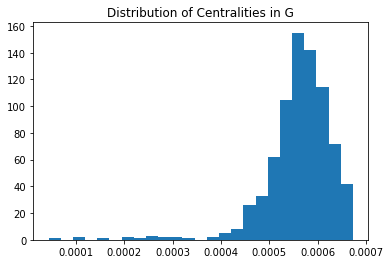

In [89]:
plt.hist([float(i) for i in np.array(list(res.items()))[:,1]], bins=25)
plt.title('Distribution of Centralities in G')
plt.show()